# WOA09 original dataset smoothing  

In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
import gsw as gsw
from netCDF4 import Dataset


from matplotlib import rcParams
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap

%matplotlib inline

In [3]:
! date

Thu Apr 17 08:53:55 CEST 2025


In [4]:
def Arc_Bat(ztype='isol1000') :
        locpath='/data0/project/drakkar/CONFIGS/CREG025.L75/GRID/'
        locfile='CREG025.L75_domain_cfg.nc'
        fieldbat=Dataset(locpath+locfile)
        lon  = np.squeeze(fieldbat.variables['nav_lon'])
        lat  = np.squeeze(fieldbat.variables['nav_lat'])
        My_var = np.squeeze(fieldbat.variables['bathy_meter'])

        spval = 0.
        My_var= np.ma.masked_where(My_var <= spval,My_var)

        if ztype == 'isol1000' :
                vmin=1000. ; vmax=2000.
                contours=[1000.]
                limits=[vmin,vmax]
                myticks=[1000.]
        elif ztype == 'isol1500' :
                vmin=1500. ; vmax=2000.
                contours=[1500.]
                limits=[vmin,vmax]
                myticks=[1500.]
        elif ztype == 'isomonarc' :
                vmin=500. ; vmax=4000.
                contours=[500.,2000.,4000.]
                limits=[vmin,vmax]
                myticks=[500.,2000.,4000.]
        elif ztype == 'isol500' :
                vmin=500. ; vmax=500.
                contours=[500.]
                limits=[vmin,vmax]
                myticks=[500.]
        else:
                vmin=0. ; vmax=8000.
                contours=[100.,500.,1000.,2000.,3000.,3500.,4000.]
                limits=[vmin,vmax]
                myticks=[100.,500.,1000.,2000.,3000.,3500.,4000.]

        #
        #rcParams['text.latex.unicode']=True
        plt.rcParams['contour.negative_linestyle'] = 'solid'
        #
        m = Basemap(projection='npstere',boundinglat=65,lon_0=-60, resolution='i')
        norm = mpl.colors.Normalize(vmin=limits[0], vmax=limits[1])
        pal = plt.cm.get_cmap('binary')
        X,Y = m(lon,lat)

        # contour (optional)
        CS2 = m.contour(X, Y, My_var, linewidths=0.5,levels=contours, colors='black', alpha=1.)
        plt.clabel(CS2, CS2.levels, inline=True, fmt='%.0f', fontsize=3)

        return m, X, Y


In [5]:
def Arc_plot(lon,lat,tab,contours,limits,myticks=None,name=None,zmy_cblab=None,zmy_cmap=None,filename='test.pdf',zvar=None):
        #
# Les 2 lignes suivantes posent un probleme a l'execution lie a LaTex ....
#       rcParams['text.usetex']=True
#       rcParams['text.latex.unicode']=True
        #rcParams['font.family']='serif'

        plt.rcParams['contour.negative_linestyle'] = 'solid'
        #
        m = Basemap(projection='npstere',boundinglat=65,lon_0=-60, resolution='i')

        if zvar == 'sivolu' or zvar == 'siconc'  or zvar == 'ssh' or zvar == 'socurl' :
                zfontsize=10.
        else:
                zfontsize=6.

        if zvar != 'Bathy' :
                m.drawparallels(np.arange(-90.,91.,5.),labels=[False,False,False,False], size=zfontsize, linewidth=0.3)
                m.drawmeridians(np.arange(-180.,181.,20.),labels=[True,False,False,True], size=zfontsize, latmax=90.,linewidth=0.3)
                m.fillcontinents(color='grey',lake_color='white')

        norm = mpl.colors.Normalize(vmin=limits[0], vmax=limits[1])

        if zmy_cmap != None :
                pal = zmy_cmap
        else:
                pal = plt.cm.get_cmap('coolwarm')
                #pal = plt.cm.get_cmap('terrain')

        X,Y = m(lon,lat)
        C = m.contourf(X,Y,tab,contours,cmap=pal,norm=norm,extend='both')
        if zvar == 'ssh':
                CS=m.contour(X, Y, tab, linewidths=0.5, levels=npy.arange(limits[0],limits[1],5.), colors='k', alpha=0.4)

        ############################################################################################################
        ############################################################################################################
        moorplot=0
        if moorplot == 1 :
                bx_ARCB={'name':'B'  ,'lon_min':-150.,'lon_max':-150.,'lat_min':78.,'lat_max':78.}
                bx_ARCM={'name':'M1' ,'lon_min': 125.,'lon_max': 125.,'lat_min':78.,'lat_max':78.}
                bx_EURA={'name':'EUR','lon_min':  60.,'lon_max':  60.,'lat_min':85.,'lat_max':85.}

                All_box=[bx_ARCB,bx_EURA]
                for box in All_box:
                        lats = [box['lat_min'],box['lat_max']]
                        lons = [box['lon_min'],box['lon_max']]
                        x,y = m(lons,lats)
                        m.scatter(x,y,3,marker='o', color='r')
                        #m.plot(x,y,linewidth=2, color='g')
        ############################################################################################################
        ############################################################################################################

        # colorbar      
        if myticks is None:
                cbar = plt.colorbar(C,format='%.2f',orientation='vertical',shrink=0.8)
        else:
                if zvar == 'votemper' or zvar == 'vosaline' or zvar == 'sivolu' :
                        cbar = plt.colorbar(C,format='%.2f',orientation='vertical',shrink=0.8,drawedges=True)
                else:
                        cbar = plt.colorbar(C,format='%.0f',orientation='vertical',shrink=0.8,drawedges=True)

                cbar.set_label(zmy_cblab,fontsize=zfontsize)
                cl = plt.getp(cbar.ax, 'ymajorticklabels')
                plt.setp(cl, fontsize=zfontsize)

        plt.title(name,fontsize=zfontsize)

        return m

In [6]:
# Funtion to compute Brunt-Vaissalla frequency and number of grid points with instability
def N2_Insta(zds,zsal,ztem,zpre):
    # Compute the Brunt-Vaissalla frequency
    WDINT_N2,p_imd=gsw.Nsquared(zds[zsal].isel(time=0).values,\
                                zds[ztem].isel(time=0).values,\
                                zpre,axis=0)

    # Build a 2D map to see how many instabilities occur on each water column
    num_WDINT_N2=np.where(WDINT_N2 < 0.,1.,0.)
    # Remove the grid points in the first 50m
    num_WDINT_N2[0:5,:,:]=0. 

    zds['Instab_sm']=(('lat','lon'),np.sum(num_WDINT_N2,axis=0))
    zds['Instab_sm']=xr.where(np.isnan(zds['CT'].isel(time=0,depth=0)),np.nan,zds['Instab_sm'])

    return zds, WDINT_N2

> # Attempt to smooth roughly the T/S vertical profiles WOA09 1deg & z24  

In [31]:
INDIR='/data0/project/drakkar/REFERENCE_DATA/WOA2009/DATA/1degx1deg/'
ds_initT=xr.open_mfdataset(INDIR+'woa09_temperature_monthly_1deg.nc',\
                          drop_variables=['t_mn','t_dd','t_dd','t_ma','t_sd','t_se','t_oa','t_gp'],\
                          decode_times=False)
ds_initT

<xarray.Dataset>
Dimensions:           (lon: 360, lat: 180, depth: 24, time: 12, nv: 2)
Coordinates:
  * lon               (lon) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * lat               (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * depth             (depth) float32 0.0 10.0 20.0 ... 1.3e+03 1.4e+03 1.5e+03
  * time              (time) float32 15.0 46.0 75.0 106.0 ... 289.0 320.0 350.0
Dimensions without coordinates: nv
Data variables:
    lat_bnds          (lat, nv) float32 dask.array<chunksize=(180, 2), meta=np.ndarray>
    lon_bnds          (lon, nv) float32 dask.array<chunksize=(360, 2), meta=np.ndarray>
    climatology_bnds  (time, nv) float32 dask.array<chunksize=(12, 2), meta=np.ndarray>
    t_an              (time, depth, lat, lon) float32 dask.array<chunksize=(12, 24, 180, 360), meta=np.ndarray>
    crs               int32 ...
Attributes: (12/40)
    CVS_ID:                     1.0
    Conventions:                CF-1.4
    id:                         75d70376-540c-4a1f-a0ca-f19f07dd7272
    naming_authority:           gov.noaa.nodc
    Metadata_Convention:        Unidata Dataset Discovery v1.0
    title:                      World Ocean Atlas 09:  Sea Water Temperature ...
    ...                         ...
    time_coverage_end:          2008-12-25
    time_coverage_duration:     P1Y
    time_coverage_resolution:   P1M
    processing_level:           synthesized product
    license:                    This data is free for anyone to use, reuse an...
    cdm_data_type:              Grid

In [32]:
INDIR='/data0/project/drakkar/REFERENCE_DATA/WOA2009/DATA/1degx1deg/'
ds_initS=xr.open_mfdataset(INDIR+'woa09_salinity_monthly_1deg.nc',\
                          drop_variables=['s_mn','s_dd','s_dd','s_ma','s_sd','s_se','s_oa','s_gp'],\
                          decode_times=False)
ds_initS

<xarray.Dataset>
Dimensions:           (lon: 360, lat: 180, depth: 24, time: 12, nv: 2)
Coordinates:
  * lon               (lon) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * lat               (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * depth             (depth) float32 0.0 10.0 20.0 ... 1.3e+03 1.4e+03 1.5e+03
  * time              (time) float32 15.0 46.0 75.0 106.0 ... 289.0 320.0 350.0
Dimensions without coordinates: nv
Data variables:
    lat_bnds          (lat, nv) float32 dask.array<chunksize=(180, 2), meta=np.ndarray>
    lon_bnds          (lon, nv) float32 dask.array<chunksize=(360, 2), meta=np.ndarray>
    climatology_bnds  (time, nv) float32 dask.array<chunksize=(12, 2), meta=np.ndarray>
    s_an              (time, depth, lat, lon) float32 dask.array<chunksize=(12, 24, 180, 360), meta=np.ndarray>
    crs               int32 ...
Attributes: (12/40)
    CVS_ID:                     1.0
    Conventions:                CF-1.4
    id:                         592ac385-a915-4d55-8f34-0f85caf22756
    naming_authority:           gov.noaa.nodc
    Metadata_Convention:        Unidata Dataset Discovery v1.0
    title:                      World Ocean Atlas 09:  Sea Water Salinity - m...
    ...                         ...
    time_coverage_end:          2008-12-25
    time_coverage_duration:     P1Y
    time_coverage_resolution:   P1M
    processing_level:           synthesized product
    license:                    This data is free for anyone to use, reuse an...
    cdm_data_type:              Grid

In [33]:
# Need to convert latitudes & longitudes into 2D field and renames their dimensions
wlat2D=np.tile(ds_initT['lat'],(ds_initT.sizes['lon'],1)).T
wzlon=np.reshape(ds_initT['lon'].data,(1,ds_initT.sizes['lon']))
wlon2D=np.tile(wzlon,(ds_initT.sizes['lat'],1))

In [10]:
ds_woa09=xr.Dataset()
ds_woa09['t_an']=(('time','depth','lat','lon'),ds_initT['t_an'].data)
ds_woa09['s_an']=(('time','depth','lat','lon'),ds_initS['s_an'].data)
ds_woa09.coords['lat']=(('lat'),ds_initT['lat'].data)
ds_woa09.coords['lon']=(('lon'),ds_initT['lon'].data)
ds_woa09.coords['depth']=(('depth'),ds_initT['depth'].data)
ds_woa09

<xarray.Dataset>
Dimensions:  (time: 12, depth: 24, lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * depth    (depth) float32 0.0 10.0 20.0 30.0 ... 1.3e+03 1.4e+03 1.5e+03
Dimensions without coordinates: time
Data variables:
    t_an     (time, depth, lat, lon) float32 dask.array<chunksize=(12, 24, 180, 360), meta=np.ndarray>
    s_an     (time, depth, lat, lon) float32 dask.array<chunksize=(12, 24, 180, 360), meta=np.ndarray>

In [11]:
wlat2D=np.tile(ds_woa09['lat'],(ds_woa09.sizes['lon'],1)).T
wlat3D=np.tile(wlat2D,(24,1,1))

wzplt=np.reshape(ds_woa09['depth'].data,(24,1,1))
wzplt.shape
# Duplicate this depth to fit the T/S on a global grid
wz3D=np.tile(wzplt,(1,ds_woa09.sizes['lat'],ds_woa09.sizes['lon']))
wz3D.shape

(24, 180, 360)

In [21]:
# Define a pressure from depth
wpressure=gsw.p_from_z(-wz3D,wlat3D)

# Units changes
ds_woa09['SA']=gsw.conversions.SA_from_SP(ds_woa09['s_an'],wpressure,ds_woa09['lon'],ds_woa09['lat'])
ds_woa09['CT']=gsw.conversions.CT_from_pt(ds_woa09['SA'],ds_woa09['t_an'])

# Calulation of the Brunt-Vaissalla frequency 
ds_out, N2_out=N2_Insta(ds_woa09,'SA','CT',wpressure)

# Save the Brunt-Vaissalla in a specific Dataset because of 1 less vertical level
ds_outN2=xr.Dataset()
ds_outN2['N2_ini']=(('depth','lat','lon'),N2_out)
ds_outN2.coords['lat']=ds_woa09['lat']
ds_outN2.coords['lon']=ds_woa09['lon']
ds_outN2.coords['depth']=ds_woa09['depth'].isel(depth=slice(0,23))

>>>> ## Smooth vertical both T/S 

In [23]:
def Fsmooth(ds_in,zvar_in,arr_ori):
    # Temperature 
    arr_sm=ds_in[zvar_in].rolling(depth=3,center=True).mean()
    # Then replace the NaN at the top and bottom of the Dataset with original field
    arr_sm[:,0,:,:]=arr_ori[:,0,:,:]
    arr_sm[:,23,:,:]=arr_ori[:,23,:,:]
    
    return arr_sm

In [24]:
# Choose which variable to smooth 
my_choice='both'  # both, sal or tem
dbl_sm=True       # Apply smoothing twice
thd_sm=True       # Apply smoothing a third time

if my_choice == 'both':
    print('>>>>>>>>>>>>>  Both CT/SA are smoothed')

    ds_woa09['CT_sm']=Fsmooth(ds_woa09,'CT',ds_woa09['CT'].data)
    ds_woa09['SA_sm']=Fsmooth(ds_woa09,'SA',ds_woa09['SA'].data)    
    ltitle='Both smoothed'
    
    if dbl_sm : 
        print('                           CT/SA smoothed twice')

        ds_woa09['CT_sm']=Fsmooth(ds_woa09,'CT_sm',ds_woa09['CT'].data)
        ds_woa09['SA_sm']=Fsmooth(ds_woa09,'SA_sm',ds_woa09['SA'].data)    
        ltitle='Both smoothed TWICE'
        
    if thd_sm : 
        print('                           CT/SA smoothed third')

        ds_woa09['CT_sm']=Fsmooth(ds_woa09,'CT_sm',ds_woa09['CT'].data)
        ds_woa09['SA_sm']=Fsmooth(ds_woa09,'SA_sm',ds_woa09['SA'].data)    
        ltitle='Both smoothed third'
            
elif my_choice == 'sal':
    print('>>>>>>>>>>>>>  Only SA is smoothed')
    ds_woa09['CT_sm']=ds_woa09['CT']
    ds_woa09['SA_sm']=Fsmooth(ds_woa09,'SA',ds_woa09['SA'].data)    

    ltitle='SA smoothed'
elif my_choice == 'tem':
    print('>>>>>>>>>>>>>  Only CT is smoothed')
    ds_woa09['SA_sm']=ds_woa09['SA']
    ds_woa09['CT_sm']=Fsmooth(ds_woa09,'CT',ds_woa09['CT'].data)
    ltitle='CT smoothed'

>>>>>>>>>>>>>  Both CT/SA are smoothed
                           CT/SA smoothed twice
                           CT/SA smoothed third


In [25]:
# Calulation of the Brunt-Vaissalla frequency 
ds_out, N2_out=N2_Insta(ds_woa09,'SA_sm','CT_sm',wpressure)

# Save the Brunt-Vaissalla in a specific Dataset because of 1 less vertical level
ds_outN2['N2_sm']=(('depth','lat','lon'),N2_out)

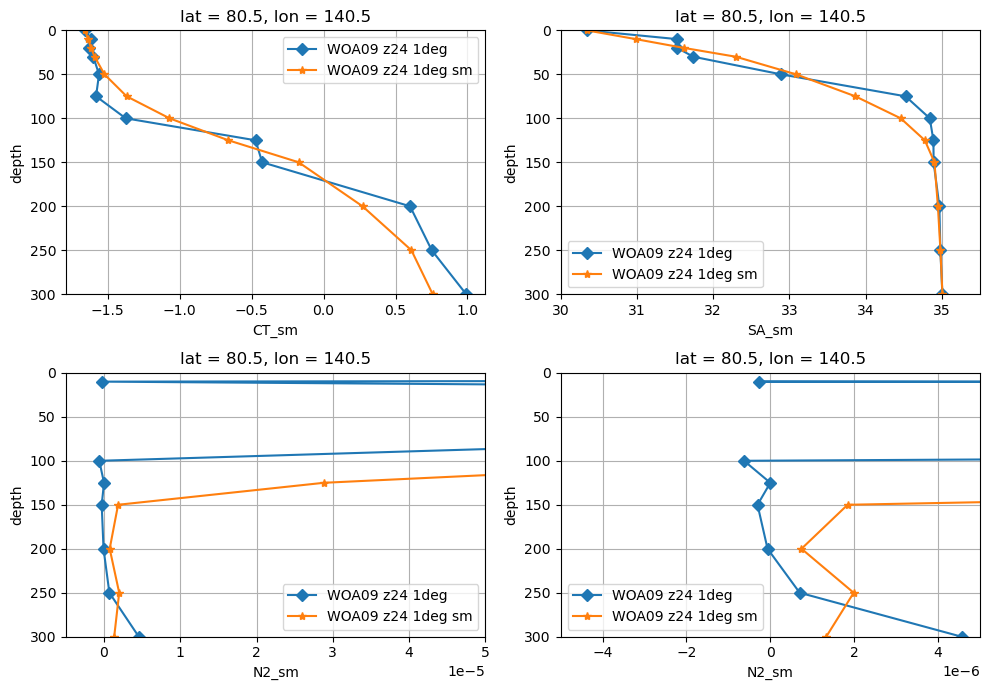

In [27]:
plt.figure(figsize=(10,7))

# Latitude & longitude
loc_x=140.  ;  loc_y=80.   ;  zdep=300.  ; zdepup=0.

plt.subplot(221)
ds_woa09['CT'].isel(time=0).sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='D',label='WOA09 z24 1deg')
ds_woa09['CT_sm'].isel(time=0).sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='*',label='WOA09 z24 1deg sm')
plt.legend()
plt.ylim([zdep,zdepup])
plt.grid(True)

plt.subplot(222)
ds_woa09['SA'].isel(time=0).sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='D',label='WOA09 z24 1deg')
ds_woa09['SA_sm'].isel(time=0).sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='*',label='WOA09 z24 1deg sm')
plt.legend()
plt.xlim([30,35.5])
plt.ylim([zdep,zdepup])
plt.grid(True)

if True:
    plt.subplot(223)
    ds_outN2['N2_ini'].sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='D',label='WOA09 z24 1deg')
    ds_outN2['N2_sm'].sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='*',label='WOA09 z24 1deg sm')

    plt.legend()
    plt.xlim([-0.5e-5,5e-5])
    plt.ylim([zdep,zdepup])
    plt.grid(True)
    
    plt.subplot(224)
    ds_outN2['N2_ini'].sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='D',label='WOA09 z24 1deg')
    ds_outN2['N2_sm'].sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='*',label='WOA09 z24 1deg sm')

    plt.legend()
    plt.xlim([-0.5e-5,0.5e-5])
    plt.ylim([zdep,zdepup])
    plt.grid(True)
    
plt.tight_layout()

Text(0.5, 1.0, 'WOA09 dataset z24 1deg \n # grid points with instabilities over the water column')

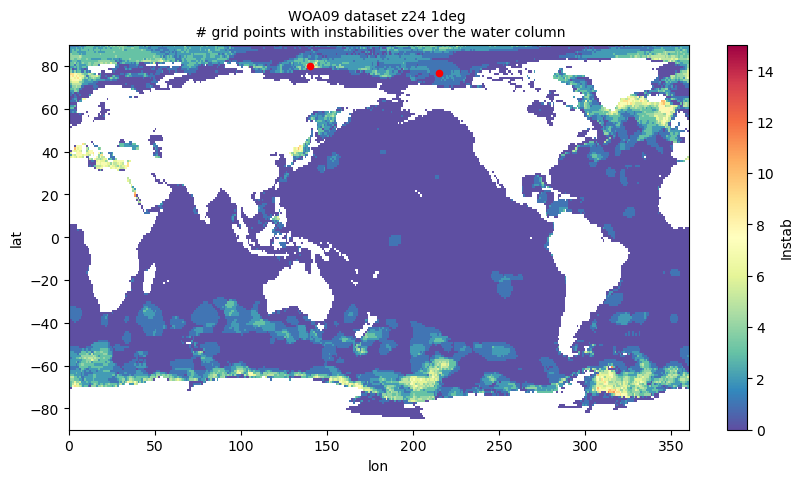

In [122]:
plt.figure(figsize=(10,5))

ds_woa09['Instab'].plot(cmap='Spectral_r',vmax=15)
# Latitude & longitude
loc_x=140  ;  loc_y=80
plt.scatter(loc_x,loc_y,20,marker='o', color='r')
loc_x=215  ;  loc_y=77
plt.scatter(loc_x,loc_y,20,marker='o', color='r')
plt.title( 'WOA09 dataset z24 1deg \n # grid points with instabilities over the water column',fontsize=10)


Text(0.5, 1.0, 'WOA09 dataset z24 1deg Both smoothed third \n # grid points with instabilities over the water column')

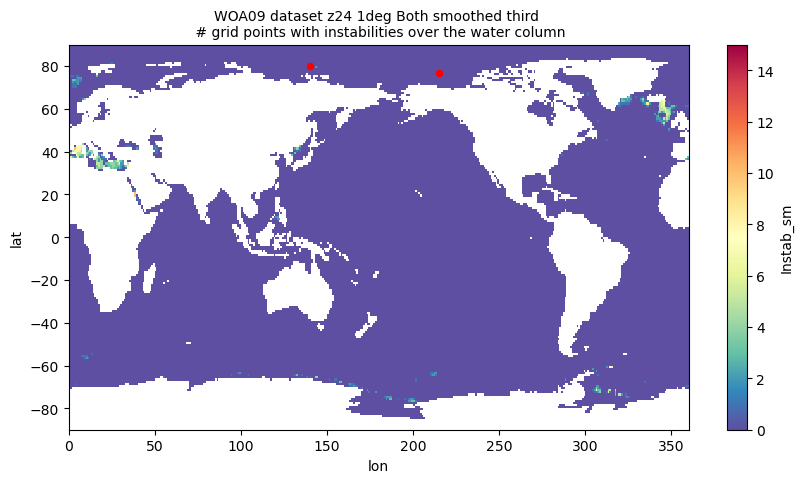

In [156]:
plt.figure(figsize=(10,5))
ds_out['Instab_sm'].plot(cmap='Spectral_r',vmax=15)
# Latitude & longitude
loc_x=140  ;  loc_y=80
plt.scatter(loc_x,loc_y,20,marker='o', color='r')
loc_x=215  ;  loc_y=77
plt.scatter(loc_x,loc_y,20,marker='o', color='r')
plt.title( 'WOA09 dataset z24 1deg '+ltitle+' \n # grid points with instabilities over the water column',fontsize=10)

/tmp/ipykernel_4702/2790957951.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pal = plt.cm.get_cmap('binary')


Text(0.5, 1.0, 'WOA09 dataset z24 1deg \n # grid points with instabilities over the water column')

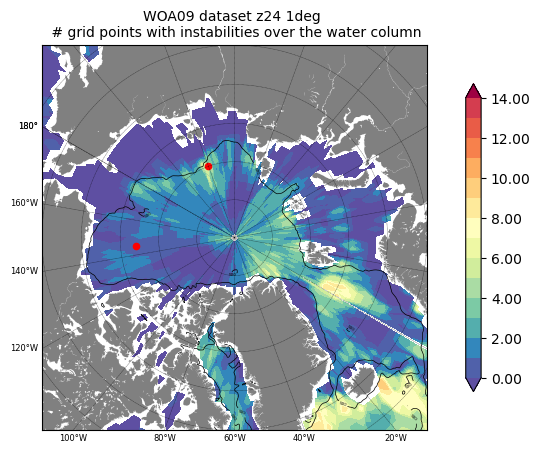

In [112]:
plt.figure(figsize=(10,5))

Arc_Bat(ztype='isol500')
m=Arc_plot(wlon2D,wlat2D,ds_woa09['Instab'],np.arange(0,15),[0.,15.],zmy_cmap='Spectral_r')
loc_x=140  ;  loc_y=80
x,y = m(loc_x,loc_y)
m.scatter(x,y,20,marker='o', color='r')
loc_x=215  ;  loc_y=77
x,y = m(loc_x,loc_y)
m.scatter(x,y,20,marker='o', color='r')
plt.title( 'WOA09 dataset z24 1deg '+ltitle+' \n # grid points with instabilities over the water column',fontsize=10)


/tmp/ipykernel_4702/2790957951.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pal = plt.cm.get_cmap('binary')


Text(0.5, 1.0, 'WOA09 dataset z24 1deg Both smoothed third \n # grid points with instabilities over the water column')

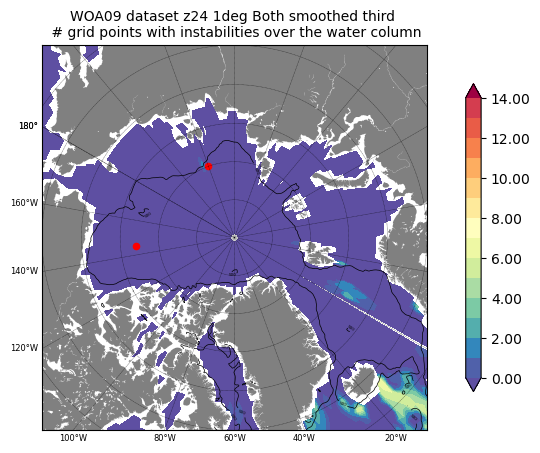

In [157]:
plt.figure(figsize=(10,5))
Arc_Bat(ztype='isol500')
m=Arc_plot(wlon2D,wlat2D,ds_out['Instab_sm'],np.arange(0,15),[0.,15.],zmy_cmap='Spectral_r')
loc_x=140  ;  loc_y=80
x,y = m(loc_x,loc_y)
m.scatter(x,y,20,marker='o', color='r')
loc_x=215  ;  loc_y=77
x,y = m(loc_x,loc_y)
m.scatter(x,y,20,marker='o', color='r')
plt.title( 'WOA09 dataset z24 1deg '+ltitle+' \n # grid points with instabilities over the water column',fontsize=10)

> # Attempt to smooth roughly the T/S vertical profiles WOA09 1deg & z33 (the combined one called CMA) 

In [27]:
def Fsmooth_Z33(ds_in,zvar_in,arr_ori):
    # Temperature 
    arr_sm=ds_in[zvar_in].rolling(depth=3,center=True).mean()
    # Then replace the NaN at the top and bottom of the Dataset with original field
    arr_sm[:,0,:,:]=arr_ori[:,0,:,:]
    arr_sm[:,32,:,:]=arr_ori[:,32,:,:]
    
    return arr_sm

In [21]:
# Funtion to compute Brunt-Vaissalla frequency and number of grid points with instability
def N2_Insta_Z33(zds,zsal,ztem,zpre,zvarout):
    # Compute the Brunt-Vaissalla frequency
    WDINT_N2,p_imd=gsw.Nsquared(zds[zsal].isel(time=0).values,\
                                zds[ztem].isel(time=0).values,\
                                zpre,axis=0)

    # Build a 2D map to see how many instabilities occur on each water column
    num_WDINT_N2=np.where(WDINT_N2 < 0.,1.,0.)
    # Remove the grid points in the first 50m
    num_WDINT_N2[0:5,:,:]=0. 
    # Remove the grid points below 1500m
    num_WDINT_N2[25::,:,:]=0. 

    zds[zvarout]=(('lat','lon'),np.sum(num_WDINT_N2,axis=0))
    zds[zvarout]=xr.where(np.isnan(zds['CT'].isel(time=0,depth=0)),np.nan,zds['Instab_sm'])

    return WDINT_N2

In [12]:
INDIR='/data0/project/drakkar/REFERENCE_DATA/WOA2009/DATA/1degx1deg/COMBINED/'
ds_initT=xr.open_mfdataset(INDIR+'woa09_temperature_monthly_1deg_t_an_CMA.nc',\
                          drop_variables=['t_mn','t_dd','t_dd','t_ma','t_sd','t_se','t_oa','t_gp','lat_bnds','lon_bnds'],\
                          decode_times=False)
ds_initT

<xarray.Dataset>
Dimensions:       (time_counter: 12, depth: 33, lat0: 180, lon0: 360)
Coordinates:
  * depth         (depth) float32 0.0 10.0 20.0 30.0 ... 4.5e+03 5e+03 5.5e+03
  * time_counter  (time_counter) float32 15.0 46.0 75.0 ... 289.0 320.0 350.0
Dimensions without coordinates: lat0, lon0
Data variables:
    t_an          (time_counter, depth, lat0, lon0) float32 dask.array<chunksize=(1, 17, 90, 180), meta=np.ndarray>
    lat           (lat0) float32 dask.array<chunksize=(180,), meta=np.ndarray>
    lon           (lon0) float32 dask.array<chunksize=(360,), meta=np.ndarray>
Attributes: (12/43)
    description:                WOA09 field for the 1degx1deg grid, combine j...
    history:                    Tue Jun 13 16:15:58 2017: ncks -A woa09_month...
    CVS_ID:                     1.0
    Conventions:                CF-1.4
    id:                         592ac385-a915-4d55-8f34-0f85caf22756
    naming_authority:           gov.noaa.nodc
    ...                         ...
    time_coverage_duration:     P1Y
    time_coverage_resolution:   P1M
    processing_level:           synthesized product
    license:                    This data is free for anyone to use, reuse an...
    cdm_data_type:              Grid
    NCO:                        4.4.2

In [13]:
INDIR='/data0/project/drakkar/REFERENCE_DATA/WOA2009/DATA/1degx1deg/COMBINED/'
ds_initS=xr.open_mfdataset(INDIR+'woa09_salinity_monthly_1deg_s_an_CMA.nc',\
                          drop_variables=['s_mn','s_dd','s_dd','s_ma','s_sd','s_se','s_oa','s_gp','lat_bnds','lon_bnds'],\
                          decode_times=False)
ds_initS

<xarray.Dataset>
Dimensions:       (time_counter: 12, depth: 33, lat0: 180, lon0: 360)
Coordinates:
  * depth         (depth) float32 0.0 10.0 20.0 30.0 ... 4.5e+03 5e+03 5.5e+03
  * time_counter  (time_counter) float32 15.0 46.0 75.0 ... 289.0 320.0 350.0
Dimensions without coordinates: lat0, lon0
Data variables:
    s_an          (time_counter, depth, lat0, lon0) float32 dask.array<chunksize=(1, 17, 90, 180), meta=np.ndarray>
    lat           (lat0) float32 dask.array<chunksize=(180,), meta=np.ndarray>
    lon           (lon0) float32 dask.array<chunksize=(360,), meta=np.ndarray>
Attributes: (12/43)
    description:                WOA09 field for the 1degx1deg grid, combine j...
    history:                    Tue Jun 13 16:16:06 2017: ncks -A woa09_month...
    CVS_ID:                     1.0
    Conventions:                CF-1.4
    id:                         592ac385-a915-4d55-8f34-0f85caf22756
    naming_authority:           gov.noaa.nodc
    ...                         ...
    time_coverage_duration:     P1Y
    time_coverage_resolution:   P1M
    processing_level:           synthesized product
    license:                    This data is free for anyone to use, reuse an...
    cdm_data_type:              Grid
    NCO:                        4.4.2

In [14]:
ds_woa09=xr.Dataset()
ds_woa09['t_an']=(('time','depth','lat','lon'),ds_initT['t_an'].data)
ds_woa09['s_an']=(('time','depth','lat','lon'),ds_initS['s_an'].data)
ds_woa09.coords['lat']=(('lat'),ds_initT['lat'].data)
ds_woa09.coords['lon']=(('lon'),ds_initT['lon'].data)
ds_woa09.coords['depth']=(('depth'),ds_initT['depth'].data)
ds_woa09

<xarray.Dataset>
Dimensions:  (time: 12, depth: 33, lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * depth    (depth) float32 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
Dimensions without coordinates: time
Data variables:
    t_an     (time, depth, lat, lon) float32 dask.array<chunksize=(1, 17, 90, 180), meta=np.ndarray>
    s_an     (time, depth, lat, lon) float32 dask.array<chunksize=(1, 17, 90, 180), meta=np.ndarray>

In [15]:
# Need to convert latitudes & longitudes into 2D field and renames their dimensions
wlat2D=np.tile(ds_woa09['lat'],(ds_woa09.sizes['lon'],1)).T
wzlon=np.reshape(ds_woa09['lon'].data,(1,ds_woa09.sizes['lon']))
wlon2D=np.tile(wzlon,(ds_woa09.sizes['lat'],1))

In [16]:
wlat2D=np.tile(ds_woa09['lat'],(ds_woa09.sizes['lon'],1)).T
wlat3D=np.tile(wlat2D,(33,1,1))

wzplt=np.reshape(ds_woa09['depth'].data,(33,1,1))
wzplt.shape
# Duplicate this depth to fit the T/S on a global grid
wz3D=np.tile(wzplt,(1,ds_woa09.sizes['lat'],ds_woa09.sizes['lon']))
wz3D.shape

(33, 180, 360)

In [22]:
# Define a pressure from depth
wpressure=gsw.p_from_z(-wz3D,wlat3D)

# Units changes
ds_woa09['SA']=gsw.conversions.SA_from_SP(ds_woa09['s_an'],wpressure,ds_woa09['lon'],ds_woa09['lat'])
ds_woa09['CT']=gsw.conversions.CT_from_pt(ds_woa09['SA'],ds_woa09['t_an'])

# Calulation of the Brunt-Vaissalla frequency 
N2_out=N2_Insta_Z33(ds_woa09,'SA','CT',wpressure,'Instab_init')

# Save the Brunt-Vaissalla in a specific Dataset because of 1 less vertical level
ds_outN2=xr.Dataset()
ds_outN2['N2_ini']=(('depth','lat','lon'),N2_out)
ds_outN2.coords['lat']=ds_woa09['lat']
ds_outN2.coords['lon']=ds_woa09['lon']
ds_outN2.coords['depth']=ds_woa09['depth'].isel(depth=slice(0,32))

In [96]:
# Choose which variable to smooth 
my_choice='both'  # both, sal or tem
num_smooth=3

if my_choice == 'both':
    print('>>>>>>>>>>>>>  Both CT/SA are smoothed')

    ds_woa09['CT_sm']=Fsmooth_Z33(ds_woa09,'CT',ds_woa09['CT'].data)
    ds_woa09['SA_sm']=Fsmooth_Z33(ds_woa09,'SA',ds_woa09['SA'].data)    
    ltitle='Both smoothed once'
   
    for zsmo in set(np.arange(num_smooth-1)+1):
        print('                      Smooth #:'+str(zsmo+1))
        ds_woa09['CT_sm']=Fsmooth_Z33(ds_woa09,'CT_sm',ds_woa09['CT'].data)
        ds_woa09['SA_sm']=Fsmooth_Z33(ds_woa09,'SA_sm',ds_woa09['SA'].data)    
    
    ltitle='Both smoothed '+str(num_smooth)+' times'


>>>>>>>>>>>>>  Both CT/SA are smoothed
                      Smooth #:2
                      Smooth #:3


In [97]:
# Calulation of the Brunt-Vaissalla frequency 
N2_out=N2_Insta_Z33(ds_woa09,'SA_sm','CT_sm',wpressure,'Instab_sm')

# Save the Brunt-Vaissalla in a specific Dataset because of 1 less vertical level
ds_outN2['N2_sm']=(('depth','lat','lon'),N2_out)

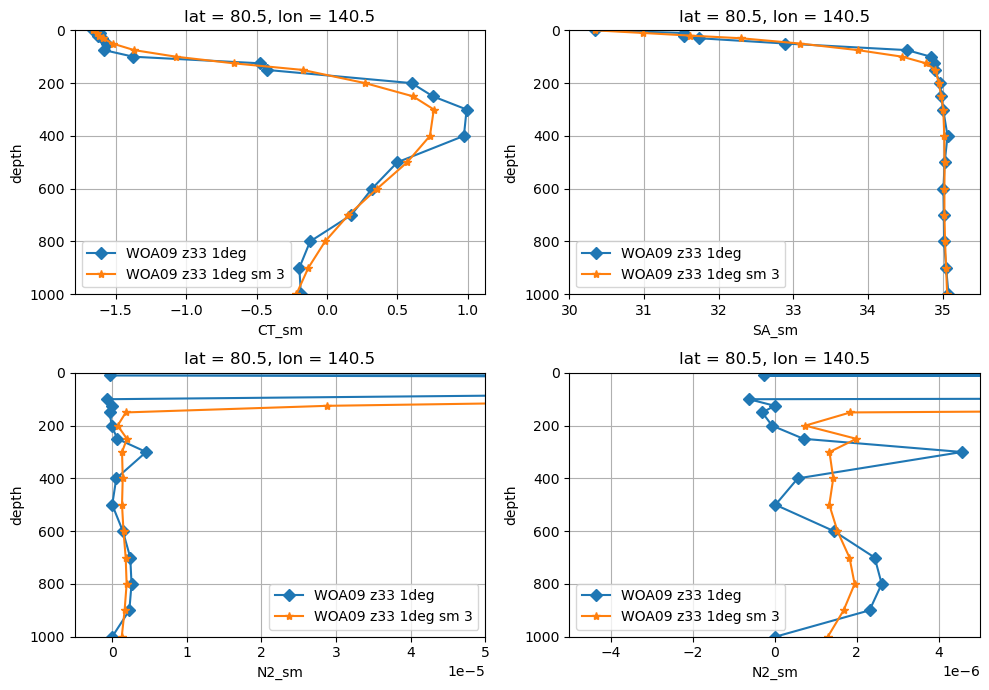

In [69]:
plt.figure(figsize=(10,7))

# Latitude & longitude
loc_x=140.  ;  loc_y=80.   ;  zdep=1000.  ; zdepup=0.

plt.subplot(221)
ds_woa09['CT'].isel(time=0).sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='D',label='WOA09 z33 1deg')
ds_woa09['CT_sm'].isel(time=0).sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='*',label='WOA09 z33 1deg sm '+str(num_smooth))
plt.legend()
plt.ylim([zdep,zdepup])
plt.grid(True)

plt.subplot(222)
ds_woa09['SA'].isel(time=0).sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='D',label='WOA09 z33 1deg')
ds_woa09['SA_sm'].isel(time=0).sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='*',label='WOA09 z33 1deg sm '+str(num_smooth))
plt.legend()
plt.xlim([30,35.5])
plt.ylim([zdep,zdepup])
plt.grid(True)

if True:
    plt.subplot(223)
    ds_outN2['N2_ini'].sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='D',label='WOA09 z33 1deg')
    ds_outN2['N2_sm'].sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='*',label='WOA09 z33 1deg sm '+str(num_smooth))

    plt.legend()
    plt.xlim([-0.5e-5,5e-5])
    plt.ylim([zdep,zdepup])
    plt.grid(True)
    
    plt.subplot(224)
    ds_outN2['N2_ini'].sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='D',label='WOA09 z33 1deg')
    ds_outN2['N2_sm'].sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='*',label='WOA09 z33 1deg sm '+str(num_smooth))

    plt.legend()
    plt.xlim([-0.5e-5,0.5e-5])
    plt.ylim([zdep,zdepup])
    plt.grid(True)
    
plt.tight_layout()

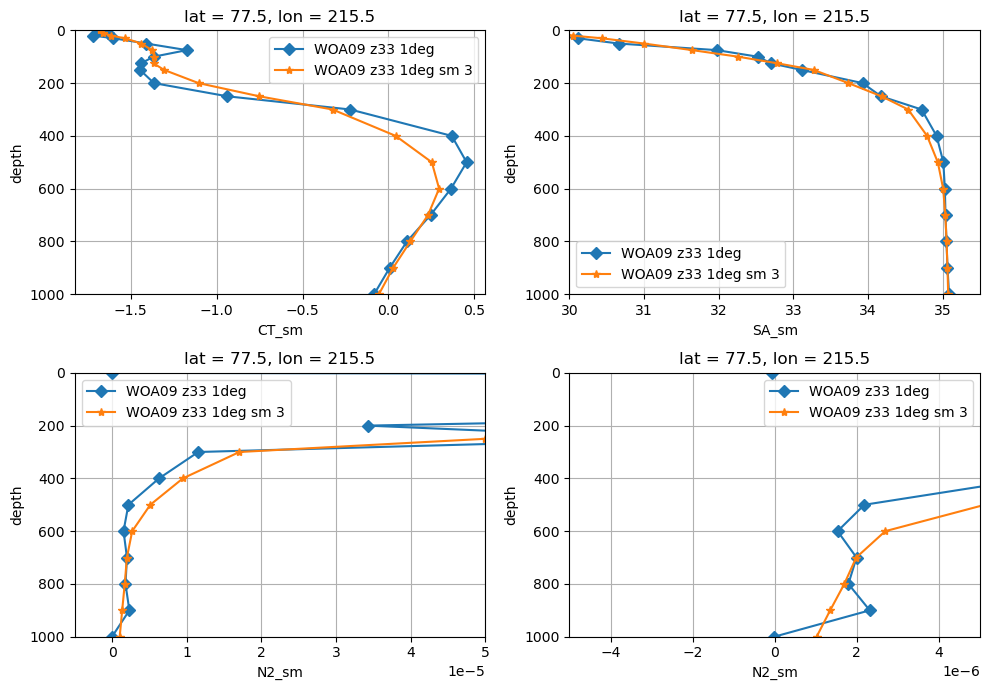

In [70]:
plt.figure(figsize=(10,7))

# Latitude & longitude
loc_x=215.  ;  loc_y=77.   ;  zdep=1000.     ; zdepup=0.

plt.subplot(221)
ds_woa09['CT'].isel(time=0).sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='D',label='WOA09 z33 1deg')
ds_woa09['CT_sm'].isel(time=0).sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='*',label='WOA09 z33 1deg sm '+str(num_smooth))
plt.legend()
plt.ylim([zdep,zdepup])
plt.ylim([zdep,0.])
plt.grid(True)

plt.subplot(222)
ds_woa09['SA'].isel(time=0).sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='D',label='WOA09 z33 1deg')
ds_woa09['SA_sm'].isel(time=0).sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='*',label='WOA09 z33 1deg sm '+str(num_smooth))
plt.legend()
plt.xlim([30,35.5])
plt.ylim([zdep,zdepup])
plt.grid(True)

if True:
    plt.subplot(223)
    ds_outN2['N2_ini'].sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='D',label='WOA09 z33 1deg')
    ds_outN2['N2_sm'].sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='*',label='WOA09 z33 1deg sm '+str(num_smooth))
    plt.legend()
    plt.xlim([-0.5e-5,5e-5])
    plt.ylim([zdep,zdepup])
    plt.grid(True)
    
    plt.subplot(224)
    ds_outN2['N2_ini'].sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='D',label='WOA09 z33 1deg')
    ds_outN2['N2_sm'].sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='*',label='WOA09 z33 1deg sm '+str(num_smooth))

    plt.legend()
    plt.xlim([-0.5e-5,0.5e-5])
    plt.ylim([zdep,zdepup])
    plt.grid(True)
    
plt.tight_layout()

Text(0.5, 1.0, 'WOA09 dataset z33 1deg \n # grid points with instabilities over the water column')

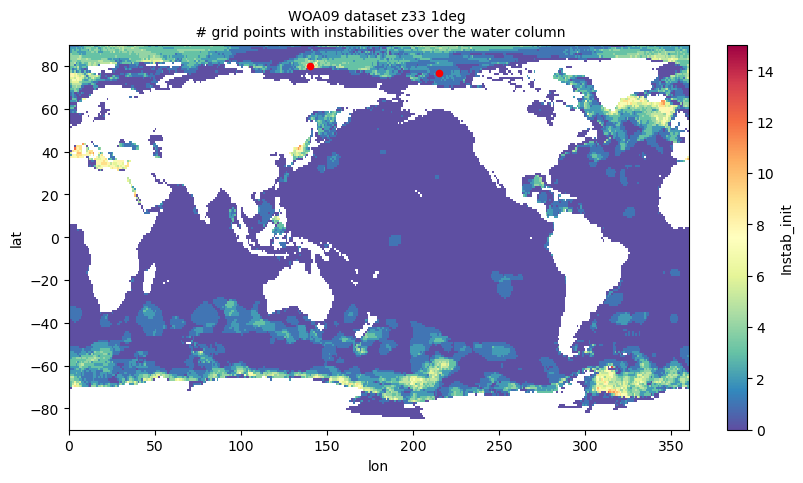

In [41]:
plt.figure(figsize=(10,5))

ds_woa09['Instab_init'].plot(cmap='Spectral_r',vmax=15)
# Latitude & longitude
loc_x=140  ;  loc_y=80
plt.scatter(loc_x,loc_y,20,marker='o', color='r')
loc_x=215  ;  loc_y=77
plt.scatter(loc_x,loc_y,20,marker='o', color='r')
plt.title( 'WOA09 dataset z33 1deg \n # grid points with instabilities over the water column',fontsize=10)


Text(0.5, 1.0, 'WOA09 dataset z33 1deg Both smoothed 3 times \n # grid points with instabilities over the water column')

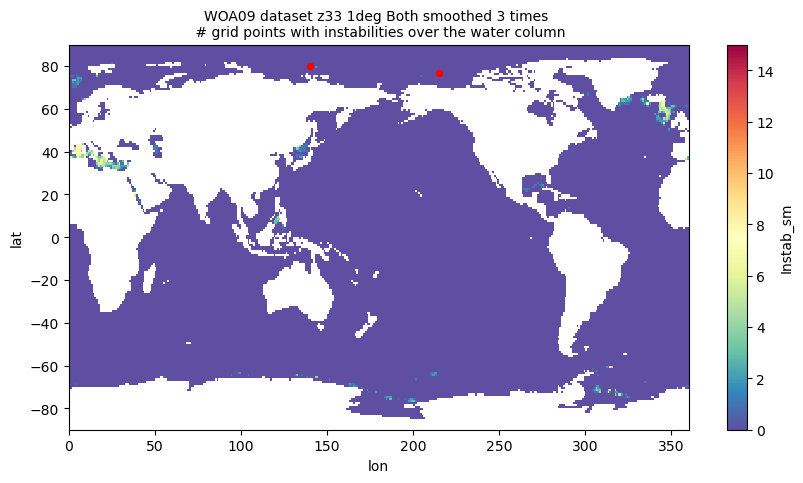

In [47]:
plt.figure(figsize=(10,5))
ds_woa09['Instab_sm'].plot(cmap='Spectral_r',vmax=15)
# Latitude & longitude
loc_x=140  ;  loc_y=80
plt.scatter(loc_x,loc_y,20,marker='o', color='r')
loc_x=215  ;  loc_y=77
plt.scatter(loc_x,loc_y,20,marker='o', color='r')
plt.title( 'WOA09 dataset z33 1deg '+ltitle+' \n # grid points with instabilities over the water column',fontsize=10)

/tmp/ipykernel_2471/2790957951.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pal = plt.cm.get_cmap('binary')


Text(0.5, 1.0, 'WOA09 dataset z33 1deg  \n # grid points with instabilities over the water column')

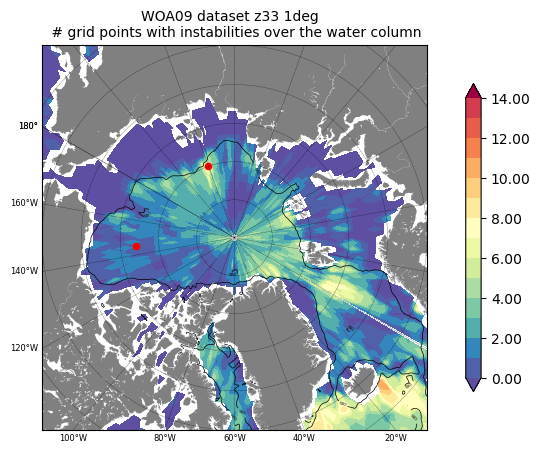

In [36]:
plt.figure(figsize=(10,5))

Arc_Bat(ztype='isol500')
m=Arc_plot(wlon2D,wlat2D,ds_woa09['Instab_init'],np.arange(0,15),[0.,15.],zmy_cmap='Spectral_r')
loc_x=140  ;  loc_y=80
x,y = m(loc_x,loc_y)
m.scatter(x,y,20,marker='o', color='r')
loc_x=215  ;  loc_y=77
x,y = m(loc_x,loc_y)
m.scatter(x,y,20,marker='o', color='r')
plt.title( 'WOA09 dataset z33 1deg  \n # grid points with instabilities over the water column',fontsize=10)


/tmp/ipykernel_2471/2790957951.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pal = plt.cm.get_cmap('binary')


Text(0.5, 1.0, 'WOA09 dataset z33 1deg Both smoothed 3 times \n # grid points with instabilities over the water column')

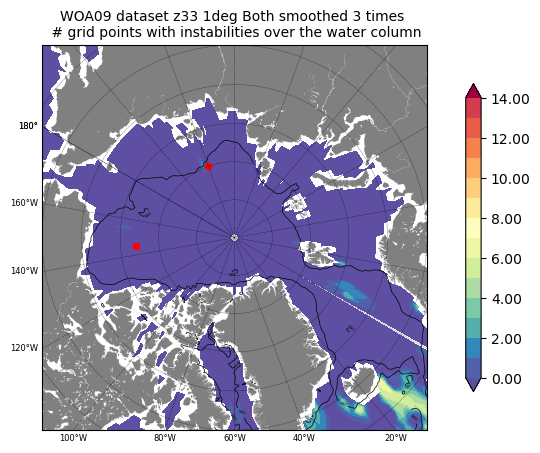

In [48]:
plt.figure(figsize=(10,5))
Arc_Bat(ztype='isol500')
m=Arc_plot(wlon2D,wlat2D,ds_woa09['Instab_sm'],np.arange(0,15),[0.,15.],zmy_cmap='Spectral_r')
loc_x=140  ;  loc_y=80
x,y = m(loc_x,loc_y)
m.scatter(x,y,20,marker='o', color='r')
loc_x=215  ;  loc_y=77
x,y = m(loc_x,loc_y)
m.scatter(x,y,20,marker='o', color='r')
plt.title( 'WOA09 dataset z33 1deg '+ltitle+' \n # grid points with instabilities over the water column',fontsize=10)

> # Plot a T/S diagram to look at the changes in water mass between the original WOA09 and the one smoothed

In [74]:
# Build the density contours 
temp=np.arange(-2.,2.,0.1) ; sal=np.arange(30.,37.,0.1)
temp2D=np.tile(temp,(sal.size,1)).T
ztmp=np.reshape(sal,(1,sal.size))
sal2D=np.tile(ztmp,(temp.size,1))

sig0=gsw.density.sigma0(sal2D,temp2D)
sig0.shape

(40, 70)

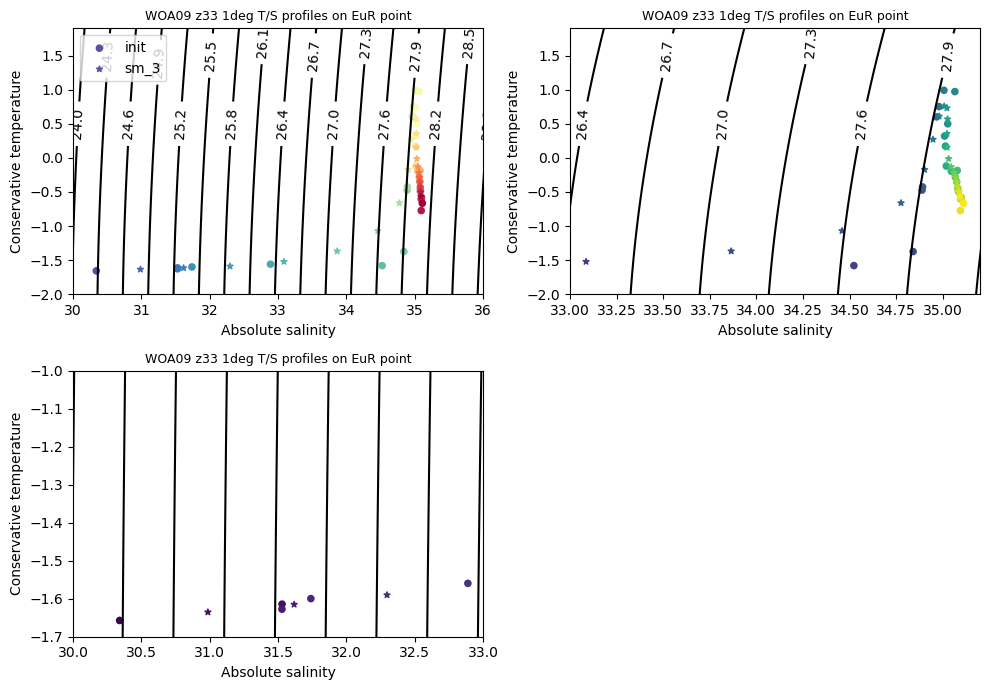

In [98]:
plt.figure(figsize=(10,7))

# Latitude & longitude
loc_x=140.  ;  loc_y=80. ; filext='EuR'  # Eurasia
#loc_x=215  ;  loc_y=77  ; filext='BfG'  # Beaufort Gyre 

tsmo='sm_'+str(num_smooth)

cast_CT=ds_woa09['CT'].isel(time=0).sel(lat=loc_y,lon=loc_x,method='nearest')
cast_SA=ds_woa09['SA'].isel(time=0).sel(lat=loc_y,lon=loc_x,method='nearest')

cast_CT_sm=ds_woa09['CT_sm'].isel(time=0).sel(lat=loc_y,lon=loc_x,method='nearest')
cast_SA_sm=ds_woa09['SA_sm'].isel(time=0).sel(lat=loc_y,lon=loc_x,method='nearest')

# Profondeurs associées (on suppose que la coordonnée verticale s'appelle 'depth')
#profondeur = ds_woa09_z75['depth'].values
profondeur=np.arange(ds_woa09.sizes['depth'])

plt.subplot(221)
CS=plt.contour(sal2D,temp2D,sig0,levels=20,colors='k')
plt.clabel(CS,CS.levels)
plt.scatter(cast_SA,cast_CT,20,marker='o',c=profondeur,label='init',cmap='Spectral_r')
plt.scatter(cast_SA_sm,cast_CT_sm,20,marker='*', c=profondeur,label=tsmo,cmap='Spectral_r')
#plt.scatter(cast_SA,cast_CT,20,marker='o',c=profondeur,norm=LogNorm(),label='init',cmap='viridis')
#plt.scatter(cast_SA_sm,cast_CT_sm,20,marker='*', c=profondeur,norm=LogNorm(),label='sm 10',cmap='viridis')
plt.title('WOA09 z33 1deg T/S profiles on '+filext+' point',fontsize=9)
plt.ylabel('Conservative temperature')
plt.xlabel('Absolute salinity')
plt.xlim([30,36])

plt.legend(loc='upper left')
#plt.grid(True)

if True :
    plt.subplot(222)
    CS=plt.contour(sal2D,temp2D,sig0,levels=20,colors='k')
    plt.clabel(CS,CS.levels)
    plt.scatter(cast_SA,cast_CT,20,marker='o', c=profondeur,label='init')
    plt.scatter(cast_SA_sm,cast_CT_sm,20,marker='*', c=profondeur, label=tsmo)
    plt.title('WOA09 z33 1deg T/S profiles on '+filext+' point',fontsize=9)
    plt.ylabel('Conservative temperature')
    plt.xlabel('Absolute salinity')
    plt.xlim([33,35.2])
    #plt.legend()
    #plt.grid(True)
if True :
    plt.subplot(223)
    CS=plt.contour(sal2D,temp2D,sig0,levels=20,colors='k')
    plt.clabel(CS,CS.levels)
    plt.scatter(cast_SA,cast_CT,20,marker='o',c=profondeur,label='init')
    plt.scatter(cast_SA_sm,cast_CT_sm,20,marker='*', c=profondeur,label=tsmo)
    plt.title('WOA09 z33 1deg T/S profiles on '+filext+' point',fontsize=9)
    plt.ylabel('Conservative temperature')
    plt.xlabel('Absolute salinity')
    plt.xlim([30,33])
    plt.ylim([-1.7,-1.])
    #plt.legend()
    #plt.grid(True)
 
plt.tight_layout()

if True:
    plt.savefig('./WOA09_z33_smoothing_DiagTS_'+filext+'_'+tsmo+'.png',dpi=300)

> # Output smoothed fields into NetCDF

In [87]:
if False:
    INDIR="./"
    #INDIR="/data0/project/drakkar/CONFIGS/CREG12.L75/CREG12.L75-I/"
    
    # From SA/CT to PS/PT units
    ds_SP=gsw.conversions.SP_from_SA(ds_woa09['SA_sm'],wpressure,ds_woa09['lon'],ds_woa09['lat'] )
    ds_PT=gsw.conversions.pt_from_CT(ds_woa09['SA_sm'],ds_woa09['CT_sm'] )
    
    ds_out=xr.Dataset()
    # Save WOA09 Practical Salinity 
    ds_out['s_an']=(('time_counter','z','lat0','lon0'),ds_SP.values)
    ds_out.coords['lat']=(('lat0'),ds_woa09['lat'].values)
    ds_out.coords['lon']=(('lon0'),ds_woa09['lon'].values)

    ds_out.attrs['History']='Salinity has been vertically smoothed '+str(num_smooth)+' times with a 3 points window '
    ds_out.to_netcdf(INDIR+'woa09_salinity_monthly_1deg_s_an_CMA_SM'+str(num_smooth)+'.nc',unlimited_dims='time_counter')
    
    ds_out=xr.Dataset()
    # Save WOA09 Potential Temperature 
    ds_out['t_an']=(('time_counter','z','lat0','lon0'),ds_PT.values)
    ds_out.coords['lat']=(('lat0'),ds_woa09['lat'].values)
    ds_out.coords['lon']=(('lon0'),ds_woa09['lon'].values)

    ds_out.attrs['History']='Temperature has been vertically smoothed '+str(num_smooth)+' times with a 3 points window '
    ds_out.to_netcdf(INDIR+'woa09_temperature_monthly_1deg_t_an_CMA_SM'+str(num_smooth)+'.nc',unlimited_dims='time_counter')

> # Now try to apply this to the WOA09 dataset interpolated on 75 levels

In [16]:
# Funtion to compute Brunt-Vaissalla frequency and number of grid points with instability
def N2_Insta_Z75(zds,zsal,ztem,zpre,zvarout,zmsk):
    # Compute the Brunt-Vaissalla frequency
    WDINT_N2,p_imd=gsw.Nsquared(zds[zsal].isel(time_counter=0).values,\
                                zds[ztem].isel(time_counter=0).values,\
                                zpre,axis=0)

    # Build a 2D map to see how many instabilities occur on each water column
    num_WDINT_N2=np.where(WDINT_N2 < 0.,1.,0.)
    # Remove the grid points in the first 50m
    num_WDINT_N2[0:18,:,:]=0. 
    # Remove the grid points below 1500m
    num_WDINT_N2[50::,:,:]=0. 

    zds[zvarout]=(('lat','lon'),np.sum(num_WDINT_N2,axis=0))
    zds[zvarout]=xr.where(np.isnan(zmsk),np.nan,zds[zvarout])

#    return zds, WDINT_N2
    return WDINT_N2

In [15]:
def Fsmooth_Z75(ds_in,zvar_in,arr_ori):
    # Temperature 
    arr_sm=ds_in[zvar_in].rolling(z=3,center=True).mean()
    # Then replace the NaN at the top and bottom of the Dataset with original field
    arr_sm[:,0,:,:]=arr_ori[:,0,:,:]
    arr_sm[:,74,:,:]=arr_ori[:,74,:,:]
    
    return arr_sm

In [6]:
INDIR='/data0/project/drakkar/CONFIGS/CREG12.L75/CREG12.L75-I/'
ds_initT=xr.open_mfdataset(INDIR+'woa09_ConTem_monthly_1deg_CT_CMA_drowned_Ex_L75.nc')
#ds_initT

In [7]:
INDIR='/data0/project/drakkar/CONFIGS/CREG12.L75/CREG12.L75-I/'
ds_initS=xr.open_mfdataset(INDIR+'woa09_SalAbs_monthly_1deg_SA_CMA_drowned_Ex_L75.nc')
#ds_initS

>>>> ## Get the original longitudes range [0,360]

In [8]:
INORI='/data0/project/drakkar/REFERENCE_DATA/WOA2009/DATA/1degx1deg/'
ds_latlon1D_0360=xr.open_dataset(INORI+'woa09_temperature_monthly_1deg.nc',\
                                 drop_variables=['lat_bnds','lon_bnds','climatology_bnds','crs','t_mn','t_dd','t_dd','t_ma','t_sd','t_se','t_oa','t_gp'],\
                                 decode_times=False)
ds_latlon1D_0360

<xarray.Dataset>
Dimensions:  (lon: 360, lat: 180, depth: 24, time: 12)
Coordinates:
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * depth    (depth) float32 0.0 10.0 20.0 30.0 ... 1.3e+03 1.4e+03 1.5e+03
  * time     (time) float32 15.0 46.0 75.0 106.0 ... 259.0 289.0 320.0 350.0
Data variables:
    t_an     (time, depth, lat, lon) float32 ...
Attributes: (12/40)
    CVS_ID:                     1.0
    Conventions:                CF-1.4
    id:                         75d70376-540c-4a1f-a0ca-f19f07dd7272
    naming_authority:           gov.noaa.nodc
    Metadata_Convention:        Unidata Dataset Discovery v1.0
    title:                      World Ocean Atlas 09:  Sea Water Temperature ...
    ...                         ...
    time_coverage_end:          2008-12-25
    time_coverage_duration:     P1Y
    time_coverage_resolution:   P1M
    processing_level:           synthesized product
    license:                    This data is free for anyone to use, reuse an...
    cdm_data_type:              Grid

>>>> ## Build land/sea mask

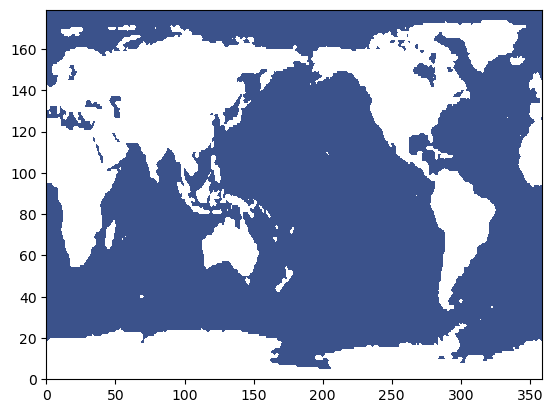

In [9]:
mask2D=xr.where(np.isnan(ds_latlon1D_0360['t_an'].isel(time=0,depth=0)),np.nan,1)
plt.contourf(mask2D)

>>>> ## Get 2D lat/lon as depth as well

In [10]:
INDIR='/data0/project/drakkar/CONFIGS/CREG12.L75/CREG12.L75-I/'
ds_latlonZ=xr.open_dataset(INDIR+'woa09_depth_Ex_L75.nc')
ds_latlonZ=ds_latlonZ.rename({'lat0':'lat','lon0':'lon'})
ds_latlonZ

<xarray.Dataset>
Dimensions:  (time_counter: 12, z: 75, lat: 180, lon: 360)
Dimensions without coordinates: time_counter, z, lat, lon
Data variables:
    depth    (time_counter, z, lat, lon) float32 ...
    lat      (lat, lon) float32 ...
    lon      (lat, lon) float32 ...

In [11]:
ds_woa09_z75=xr.Dataset()
ds_woa09_z75['SA']=(('time_counter','z','lat','lon'),ds_initS['SA'].data)
ds_woa09_z75['CT']=(('time_counter','z','lat','lon'),ds_initT['CT'].data)
ds_woa09_z75.coords['lat']=(('lat'),ds_latlon1D_0360['lat'].data)
ds_woa09_z75.coords['lon']=(('lon'),ds_latlon1D_0360['lon'].data)
ds_woa09_z75.coords['depth']=(('z'),ds_latlonZ['depth'].isel(time_counter=0,lat=0,lon=0).data)
ds_woa09_z75

<xarray.Dataset>
Dimensions:  (time_counter: 12, z: 75, lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
    depth    (z) float32 0.5058 1.556 2.668 ... 5.495e+03 5.698e+03 5.902e+03
Dimensions without coordinates: time_counter, z
Data variables:
    SA       (time_counter, z, lat, lon) float64 dask.array<chunksize=(12, 75, 180, 360), meta=np.ndarray>
    CT       (time_counter, z, lat, lon) float64 dask.array<chunksize=(12, 75, 180, 360), meta=np.ndarray>

In [12]:
zzlat3D=np.reshape(ds_woa09_z75['lat'].data,(ds_woa09_z75.sizes['lat'],1))
zlat3D=np.tile(zzlat3D,(1,ds_woa09_z75.sizes['lon']))
lat3D=np.tile(zlat3D,(ds_woa09_z75.sizes['z'],1,1))
zplt=np.reshape(ds_woa09_z75['depth'].data,(ds_woa09_z75.sizes['z'],1,1))
zplt.shape
# Duplicate this depth to fit the T/S on a global grid
z3D=np.tile(zplt,(1,ds_woa09_z75.sizes['lat'],ds_woa09_z75.sizes['lon']))
lat3D.shape

(75, 180, 360)

In [13]:
# Define a pressure from depth
pressure=gsw.p_from_z(-z3D,lat3D)

In [19]:
# Calulation of the Brunt-Vaissalla frequency 
N2_out=N2_Insta_Z75(ds_woa09_z75,'SA','CT',pressure,'Instab_init',mask2D)

# Save the Brunt-Vaissalla in a specific Dataset because of 1 less vertical level
ds_outN2_Z75=xr.Dataset()
ds_outN2_Z75['N2_ini']=(('z','lat','lon'),N2_out)
ds_outN2_Z75.coords['lat']=ds_woa09_z75['lat']
ds_outN2_Z75.coords['lon']=ds_woa09_z75['lon']
ds_outN2_Z75.coords['depth']=ds_woa09_z75['depth'].isel(z=slice(0,74))

In [62]:
# Choose which variable to smooth 
my_choice='both'  # both, sal or tem
num_smooth=3

if my_choice == 'both':
    print('>>>>>>>>>>>>>  Both CT/SA are smoothed')

    ds_woa09_z75['CT_sm']=Fsmooth_Z75(ds_woa09_z75,'CT',ds_woa09_z75['CT'].data)
    ds_woa09_z75['SA_sm']=Fsmooth_Z75(ds_woa09_z75,'SA',ds_woa09_z75['SA'].data)    
    ltitle='Both smoothed once'
   
    for zsmo in set(np.arange(num_smooth-1)+1):
        print('                      Smooth #:'+str(zsmo+1))
        ds_woa09_z75['CT_sm']=Fsmooth_Z75(ds_woa09_z75,'CT_sm',ds_woa09_z75['CT'].data)
        ds_woa09_z75['SA_sm']=Fsmooth_Z75(ds_woa09_z75,'SA_sm',ds_woa09_z75['SA'].data)    
    
    ltitle='Both smoothed '+str(num_smooth)+' times'
    
elif my_choice == 'sal':
    print('>>>>>>>>>>>>>  Only SA is smoothed')
    ds_woa09_z75['CT_sm']=ds_woa09_z75['CT']
    ds_woa09_z75['SA_sm']=Fsmooth_Z75(ds_woa09_z75,'SA',ds_woa09_z75['SA'].data)    

    ltitle='SA smoothed'
elif my_choice == 'tem':
    print('>>>>>>>>>>>>>  Only CT is smoothed')
    ds_woa09_z75['SA_sm']=ds_woa09_z75['SA']
    ds_woa09_z75['CT_sm']=Fsmooth_Z75(ds_woa09_z75,'CT',ds_woa09_z75['CT'].data)
    ltitle='CT smoothed'

>>>>>>>>>>>>>  Both CT/SA are smoothed
                      Smooth #:2
                      Smooth #:3


In [63]:
# Calulation of the Brunt-Vaissalla frequency 
N2_out=N2_Insta_Z75(ds_woa09_z75,'SA_sm','CT_sm',pressure,'Instab_sm',mask2D)

# Save the Brunt-Vaissalla in a specific Dataset because of 1 less vertical level
ds_outN2_Z75['N2_sm']=(('z','lat','lon'),N2_out)


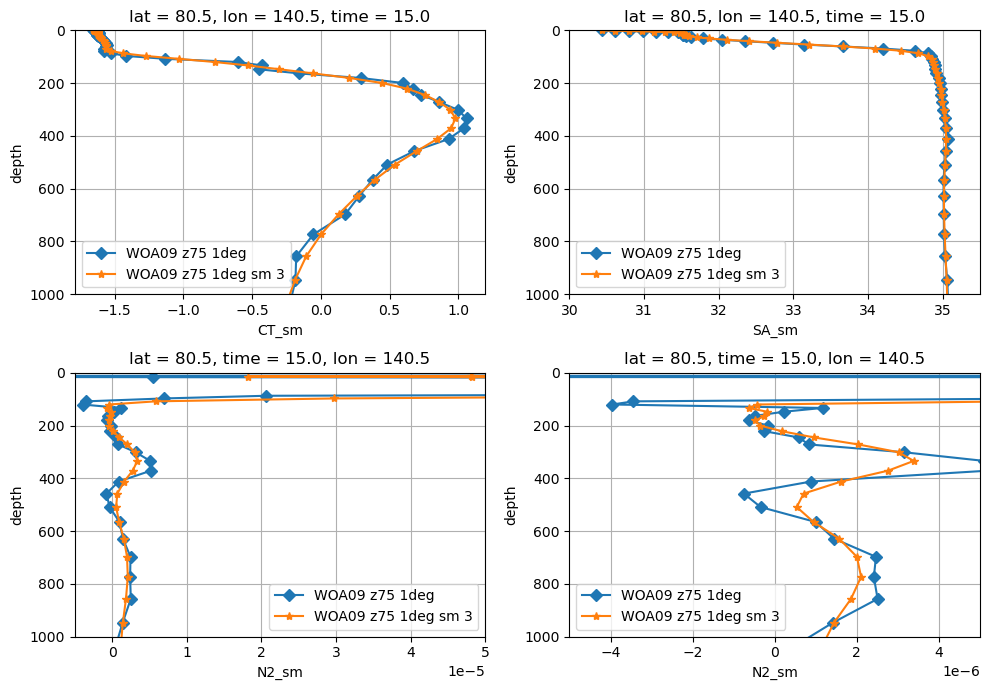

In [64]:
plt.figure(figsize=(10,7))

# Latitude & longitude
loc_x=140.  ;  loc_y=80.   ;  zdep=1000.  ; zdepup=0.

plt.subplot(221)
ds_woa09_z75['CT'].isel(time_counter=0).sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='D',label='WOA09 z75 1deg')
ds_woa09_z75['CT_sm'].isel(time_counter=0).sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='*',label='WOA09 z75 1deg sm '+str(num_smooth))
plt.legend()
plt.ylim([zdep,zdepup])
plt.grid(True)

plt.subplot(222)
ds_woa09_z75['SA'].isel(time_counter=0).sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='D',label='WOA09 z75 1deg')
ds_woa09_z75['SA_sm'].isel(time_counter=0).sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='*',label='WOA09 z75 1deg sm '+str(num_smooth))
plt.legend()
plt.xlim([30,35.5])
plt.ylim([zdep,zdepup])
plt.grid(True)

if True:
    plt.subplot(223)
    ds_outN2_Z75['N2_ini'].sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='D',label='WOA09 z75 1deg')
    ds_outN2_Z75['N2_sm'].sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='*',label='WOA09 z75 1deg sm '+str(num_smooth))

    plt.legend()
    plt.xlim([-0.5e-5,5e-5])
    plt.ylim([zdep,zdepup])
    plt.grid(True)
    
    plt.subplot(224)
    ds_outN2_Z75['N2_ini'].sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='D',label='WOA09 z75 1deg')
    ds_outN2_Z75['N2_sm'].sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='*',label='WOA09 z75 1deg sm '+str(num_smooth))

    plt.legend()
    plt.xlim([-0.5e-5,0.5e-5])
    plt.ylim([zdep,zdepup])
    plt.grid(True)
    
plt.tight_layout()

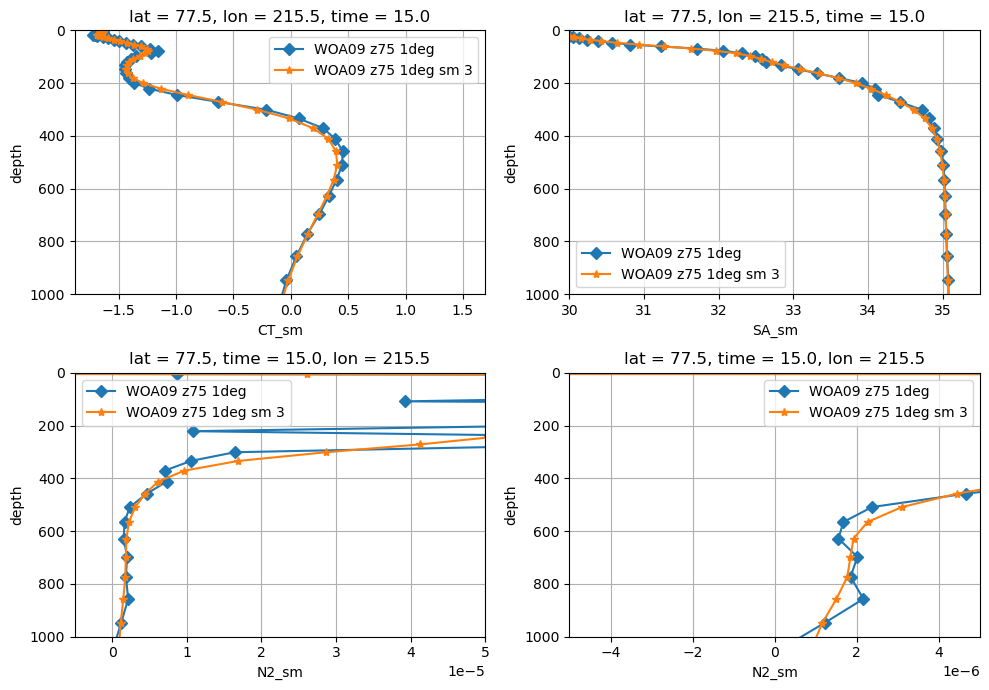

In [65]:
plt.figure(figsize=(10,7))

# Latitude & longitude
loc_x=215.  ;  loc_y=77.   ;  zdep=1000.     ; zdepup=0.

plt.subplot(221)
ds_woa09_z75['CT'].isel(time_counter=0).sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='D',label='WOA09 z75 1deg')
ds_woa09_z75['CT_sm'].isel(time_counter=0).sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='*',label='WOA09 z75 1deg sm '+str(num_smooth))
plt.legend()
plt.ylim([zdep,zdepup])
plt.ylim([zdep,0.])
plt.grid(True)

plt.subplot(222)
ds_woa09_z75['SA'].isel(time_counter=0).sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='D',label='WOA09 z75 1deg')
ds_woa09_z75['SA_sm'].isel(time_counter=0).sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='*',label='WOA09 z75 1deg sm '+str(num_smooth))
plt.legend()
plt.xlim([30,35.5])
plt.ylim([zdep,zdepup])
plt.grid(True)

if True:
    plt.subplot(223)
    ds_outN2_Z75['N2_ini'].sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='D',label='WOA09 z75 1deg')
    ds_outN2_Z75['N2_sm'].sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='*',label='WOA09 z75 1deg sm '+str(num_smooth))
    plt.legend()
    plt.xlim([-0.5e-5,5e-5])
    plt.ylim([zdep,zdepup])
    plt.grid(True)
    
    plt.subplot(224)
    ds_outN2_Z75['N2_ini'].sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='D',label='WOA09 z75 1deg')
    ds_outN2_Z75['N2_sm'].sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='*',label='WOA09 z75 1deg sm '+str(num_smooth))

    plt.legend()
    plt.xlim([-0.5e-5,0.5e-5])
    plt.ylim([zdep,zdepup])
    plt.grid(True)
    
plt.tight_layout()

Text(0.5, 1.0, 'WOA09 dataset z75 1deg \n # grid points with instabilities over the water column')

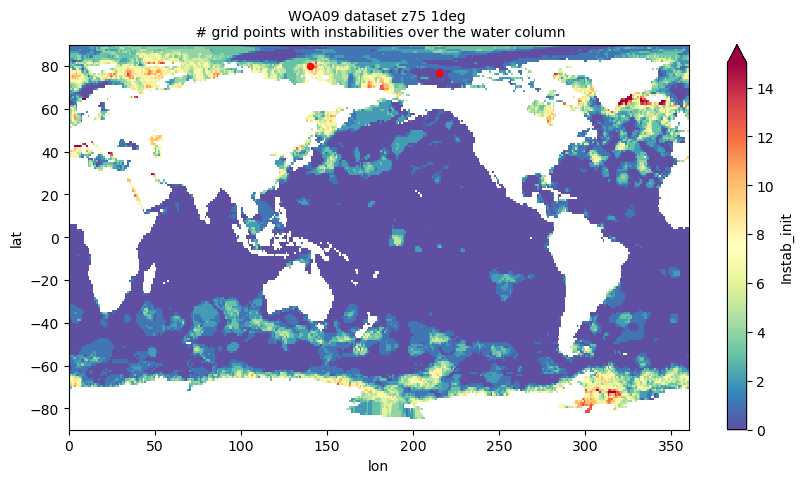

In [107]:
plt.figure(figsize=(10,5))

ds_woa09_z75['Instab_init'].plot(cmap='Spectral_r',vmax=15)
# Latitude & longitude
loc_x=140  ;  loc_y=80
plt.scatter(loc_x,loc_y,20,marker='o', color='r')
loc_x=215  ;  loc_y=77
plt.scatter(loc_x,loc_y,20,marker='o', color='r')
plt.title( 'WOA09 dataset z75 1deg \n # grid points with instabilities over the water column',fontsize=10)


/tmp/ipykernel_16074/2790957951.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pal = plt.cm.get_cmap('binary')


Text(0.5, 1.0, 'WOA09 dataset z75 1deg \n # grid points with instabilities over the water column')

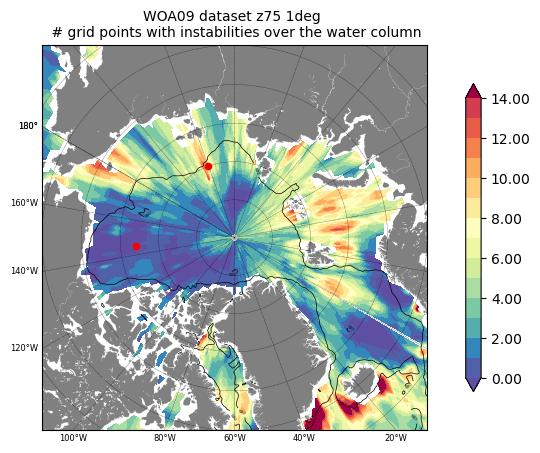

In [110]:
plt.figure(figsize=(10,5))

Arc_Bat(ztype='isol500')
m=Arc_plot(wlon2D,wlat2D,ds_woa09_z75['Instab_init'],np.arange(0,15),[0.,15.],zmy_cmap='Spectral_r')
loc_x=140  ;  loc_y=80
x,y = m(loc_x,loc_y)
m.scatter(x,y,20,marker='o', color='r')
loc_x=215  ;  loc_y=77
x,y = m(loc_x,loc_y)
m.scatter(x,y,20,marker='o', color='r')
plt.title( 'WOA09 dataset z75 1deg \n # grid points with instabilities over the water column',fontsize=10)


Text(0.5, 1.0, 'WOA09 dataset z75 1deg Both smoothed 10 times \n # grid points with instabilities over the water column')

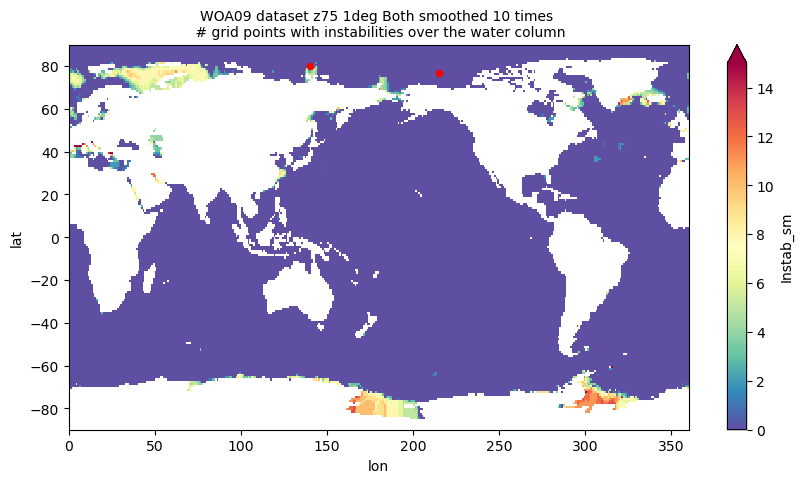

In [192]:
plt.figure(figsize=(10,5))

ds_woa09_z75['Instab_sm'].plot(cmap='Spectral_r',vmax=15)
# Latitude & longitude
loc_x=140  ;  loc_y=80
plt.scatter(loc_x,loc_y,20,marker='o', color='r')
loc_x=215  ;  loc_y=77
plt.scatter(loc_x,loc_y,20,marker='o', color='r')
plt.title( 'WOA09 dataset z75 1deg '+ltitle+' \n # grid points with instabilities over the water column',fontsize=10)


/tmp/ipykernel_16074/2790957951.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pal = plt.cm.get_cmap('binary')


Text(0.5, 1.0, 'WOA09 dataset z75 1deg Both smoothed 10 times \n # grid points with instabilities over the water column')

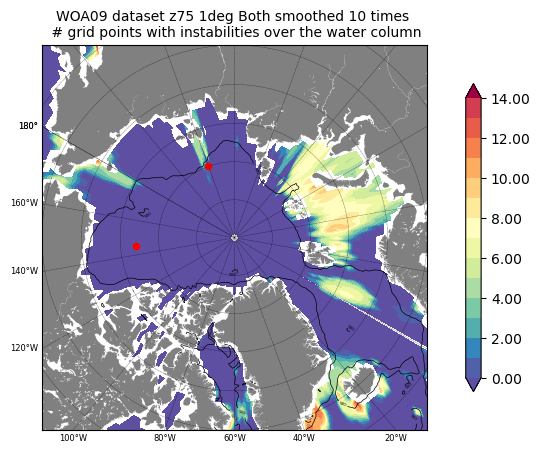

In [193]:
plt.figure(figsize=(10,5))

Arc_Bat(ztype='isol500')
m=Arc_plot(wlon2D,wlat2D,ds_woa09_z75['Instab_sm'],np.arange(0,15),[0.,15.],zmy_cmap='Spectral_r')
loc_x=140  ;  loc_y=80
x,y = m(loc_x,loc_y)
m.scatter(x,y,20,marker='o', color='r')
loc_x=215  ;  loc_y=77
x,y = m(loc_x,loc_y)
m.scatter(x,y,20,marker='o', color='r')
plt.title( 'WOA09 dataset z75 1deg '+ltitle+' \n # grid points with instabilities over the water column',fontsize=10)


> # Output into NetCDF

In [66]:
if False:
    INDIR="./"
    #INDIR="/data0/project/drakkar/CONFIGS/CREG12.L75/CREG12.L75-I/"
    
    # From SA/CT to PS/PT units
    ds_SP=gsw.conversions.SP_from_SA(ds_woa09_z75['SA_sm'],pressure,ds_woa09_z75['lon'],ds_woa09_z75['lat'] )
    ds_PT=gsw.conversions.pt_from_CT(ds_woa09_z75['SA_sm'],ds_woa09_z75['CT_sm'] )
    
    ds_out=xr.Dataset()
    # Save WOA09 Practical Salinity 
    ds_out['s_an']=(('time_counter','z','lat0','lon0'),ds_SP.values)
    ds_out.coords['lat']=(('lat0'),ds_woa09_z75['lat'].values)
    ds_out.coords['lon']=(('lon0'),ds_woa09_z75['lon'].values)

    ds_out.attrs['History']='Salinity has been vertically smoothed 3 times with a 3 points window '
    ds_out.to_netcdf(INDIR+'woa09_salinity_monthly_1deg_s_an_CMA_drowned_Ex_L75_SM3.nc',unlimited_dims='time_counter')
    
    ds_out=xr.Dataset()
    # Save WOA09 Potential Temperature 
    ds_out['t_an']=(('time_counter','z','lat0','lon0'),ds_PT.values)
    ds_out.coords['lat']=(('lat0'),ds_woa09_z75['lat'].values)
    ds_out.coords['lon']=(('lon0'),ds_woa09_z75['lon'].values)

    ds_out.attrs['History']='Temperature has been vertically smoothed 3 times with a 3 points window '
    ds_out.to_netcdf(INDIR+'woa09_temperature_monthly_1deg_t_an_CMA_drowned_Ex_L75_SM3.nc',unlimited_dims='time_counter')

> # Plot a T/S diagram to look at the changes in water mass between the original WOA09 and the one smoothed

In [24]:
# Build the density contours 
temp=np.arange(-2.,2.,0.1) ; sal=np.arange(30.,37.,0.1)
temp2D=np.tile(temp,(sal.size,1)).T
ztmp=np.reshape(sal,(1,sal.size))
sal2D=np.tile(ztmp,(temp.size,1))

sig0=gsw.density.sigma0(sal2D,temp2D)
sig0.shape

(40, 70)

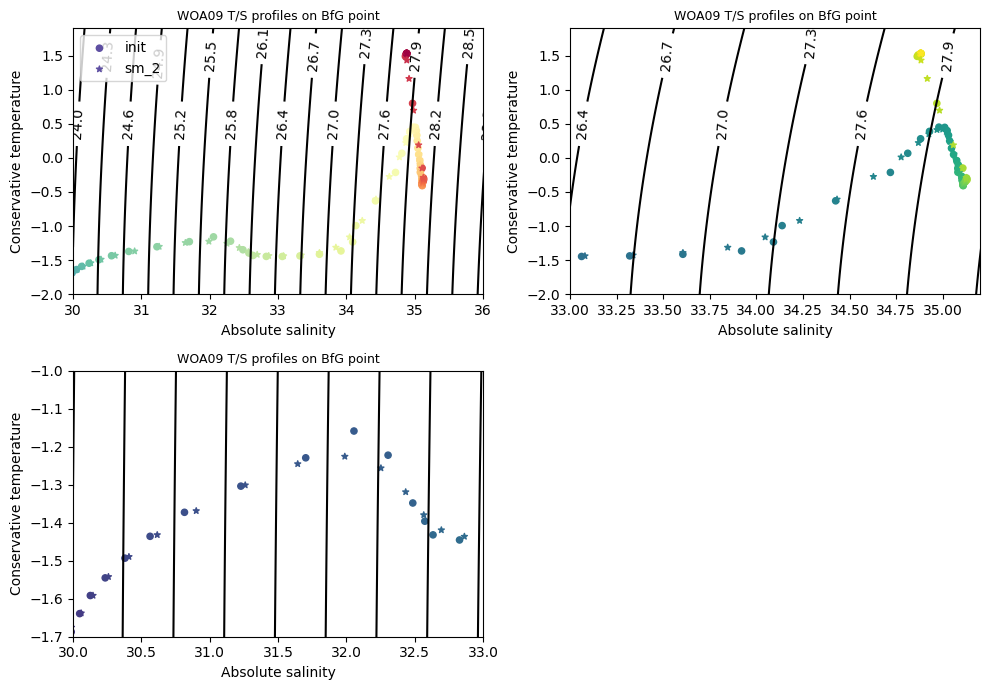

In [58]:
plt.figure(figsize=(10,7))

# Latitude & longitude
#loc_x=140.  ;  loc_y=80. ; filext='EuR'  # Eurasia
loc_x=215  ;  loc_y=77  ; filext='BfG'  # Beaufort Gyre 

tsmo='sm_'+str(num_smooth)

cast_CT=ds_woa09_z75['CT'].isel(time_counter=0).sel(lat=loc_y,lon=loc_x,method='nearest')
cast_SA=ds_woa09_z75['SA'].isel(time_counter=0).sel(lat=loc_y,lon=loc_x,method='nearest')

cast_CT_sm=ds_woa09_z75['CT_sm'].isel(time_counter=0).sel(lat=loc_y,lon=loc_x,method='nearest')
cast_SA_sm=ds_woa09_z75['SA_sm'].isel(time_counter=0).sel(lat=loc_y,lon=loc_x,method='nearest')

# Profondeurs associées (on suppose que la coordonnée verticale s'appelle 'depth')
#profondeur = ds_woa09_z75['depth'].values
profondeur=np.arange(ds_woa09_z75.sizes['z'])

plt.subplot(221)
CS=plt.contour(sal2D,temp2D,sig0,levels=20,colors='k')
plt.clabel(CS,CS.levels)
plt.scatter(cast_SA,cast_CT,20,marker='o',c=profondeur,label='init',cmap='Spectral_r')
plt.scatter(cast_SA_sm,cast_CT_sm,20,marker='*', c=profondeur,label=tsmo,cmap='Spectral_r')
#plt.scatter(cast_SA,cast_CT,20,marker='o',c=profondeur,norm=LogNorm(),label='init',cmap='viridis')
#plt.scatter(cast_SA_sm,cast_CT_sm,20,marker='*', c=profondeur,norm=LogNorm(),label='sm 10',cmap='viridis')
plt.title('WOA09 T/S profiles on '+filext+' point',fontsize=9)
plt.ylabel('Conservative temperature')
plt.xlabel('Absolute salinity')
plt.xlim([30,36])

plt.legend(loc='upper left')
#plt.grid(True)

if True :
    plt.subplot(222)
    CS=plt.contour(sal2D,temp2D,sig0,levels=20,colors='k')
    plt.clabel(CS,CS.levels)
    plt.scatter(cast_SA,cast_CT,20,marker='o', c=profondeur,label='init')
    plt.scatter(cast_SA_sm,cast_CT_sm,20,marker='*', c=profondeur, label=tsmo)
    plt.title('WOA09 T/S profiles on '+filext+' point',fontsize=9)
    plt.ylabel('Conservative temperature')
    plt.xlabel('Absolute salinity')
    plt.xlim([33,35.2])
    #plt.legend()
    #plt.grid(True)
if True :
    plt.subplot(223)
    CS=plt.contour(sal2D,temp2D,sig0,levels=20,colors='k')
    plt.clabel(CS,CS.levels)
    plt.scatter(cast_SA,cast_CT,20,marker='o',c=profondeur,label='init')
    plt.scatter(cast_SA_sm,cast_CT_sm,20,marker='*', c=profondeur,label=tsmo)
    plt.title('WOA09 T/S profiles on '+filext+' point',fontsize=9)
    plt.ylabel('Conservative temperature')
    plt.xlabel('Absolute salinity')
    plt.xlim([30,33])
    plt.ylim([-1.7,-1.])
    #plt.legend()
    #plt.grid(True)
 
plt.tight_layout()

if True:
    plt.savefig('./WOA09_z75_smoothing_DiagTS_'+filext+'_'+tsmo+'.png',dpi=300)